Link to kaggle dataset - https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_train.csv

In [117]:
import re
import time
import string
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import gensim.models as gsm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import nltk
import plotly.express as px
from collections import Counter
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors


# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemzaharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/artemzaharov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/artemzaharov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Preprocessing

## Preprocessing Steps

The preprocessing function in this notebook is designed to clean, lemmatize, and vectorize text data, as well as extract and vectorize emojis. Below are the detailed steps involved in the preprocessing pipeline:

1. **Text Cleaning**:
   - The text is converted to lowercase to ensure uniformity.
   - Any text within square brackets is removed to eliminate unnecessary content.
   - Punctuation marks are stripped from the text.
   - Words containing numbers are removed to focus on purely textual data.
   - Non-UTF-8 characters, except emojis, are removed.
   - Extra whitespace is removed to tidy up the text.

2. **Lemmatization**:
   - The cleaned text is lemmatized to reduce words to their base or root form, aiding in better understanding and analysis.
   - Common stopwords are removed during this process to focus on meaningful words.

3. **Emoji Extraction**:
   - Emojis are extracted from the original text using a predefined pattern. This helps in understanding the sentiment and emotion conveyed in the text.

4. **Label Encoding**:
   - Sentiment labels are encoded into numerical values using LabelEncoder, facilitating their use in machine learning models.

5. **Text Vectorization**:
   - The lemmatized text is vectorized using a pre-trained Word2Vec model. This converts the text into numerical vectors that can be used as input features for machine learning algorithms.

6. **Emoji Vectorization**:
   - Emojis are vectorized using a pre-trained Emoji2Vec model, similar to the text vectorization process. This helps in incorporating the semantic meaning of emojis into the analysis.

7. **Combining Text and Emoji Embeddings**:
   - The text and emoji embeddings are combined to form a comprehensive feature set for the machine learning model.

8. **Data Splitting**:
   - The combined feature set is split into training and testing sets to evaluate the performance of the machine learning model.

Throughout the preprocessing pipeline, the time taken for each step is measured and printed, providing insights into the efficiency of the process. The final output of the function includes the training and testing sets ready for model training and evaluation.


In [118]:
# Define the function to extract emojis
def extract_emojis(text):
    emoji_pattern = re.compile(pattern="["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                          "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

def extract_unique_emojis(df):
    all_emojis = set()
    for emoji_list in df['emojis']:
        for emojis in emoji_list:
            all_emojis.update(list(emojis))
    return list(all_emojis)

# Define the function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove all non UTF-8 signs except emojis
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and strip text

    return text

# Define the function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in (stopwords.words('english')+['this', 'that', 'get', 'got', 'thanks', 'would'])]
    return ' '.join(words)

# Preprocessing function
def preprocess_data(data):
    start_time = time.time()

    # Text Cleaning
    clean_start_time = time.time()
    print("Cleaning text...")
    data['cleaned_text'] = data['Text'].apply(clean_text)
    print(f"Text cleaned in {time.time() - clean_start_time:.2f} seconds\n")

    # Lemmatization
    lemmatization_start_time = time.time()
    print("Lemmatizing text...")
    data['lemmatized_text'] = data['cleaned_text'].apply(lemmatize_text)
    print(f"Text lemmatized in {time.time() - lemmatization_start_time:.2f} seconds\n")

    # Extract Emojis
    emoji_extraction_start_time = time.time()
    print("Extracting emojis...")
    data['emojis'] = data['Text'].apply(extract_emojis)
    print(f"Emojis extracted in {time.time() - emoji_extraction_start_time:.2f} seconds\n")

    # Encode the target labels
    label_encoding_start_time = time.time()
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['Sentiment'])
    print(f"Labels encoded in {time.time() - label_encoding_start_time:.2f} seconds\n")

    # Vectorize the text using Word2Vec
    vectorization_start_time = time.time()
    print("Vectorizing text...")
    word2vec_model = KeyedVectors.load_word2vec_format('ADVB data/GoogleNews-vectors-negative300.bin', binary=True)

    def get_word2vec_embeddings(text):
        words = text.split()
        embeddings = [word2vec_model[word] for word in words if word in word2vec_model]
        if embeddings:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(300)  # Assuming 300-dimension word vectors

    data['text_embeddings'] = data['lemmatized_text'].apply(get_word2vec_embeddings)
    print(f"Text vectorized in {time.time() - vectorization_start_time:.2f} seconds\n")

    # Vectorize the emojis using Emoji2Vec
    emoji_vectorization_start_time = time.time()
    print("Vectorizing emojis...")
    emoji2vec_model = KeyedVectors.load_word2vec_format('ADVB data/emoji2vec.bin', binary=True)

    def get_emoji2vec_embeddings(emojis):
        embeddings = [emoji2vec_model[emoji] for emoji in emojis if emoji in emoji2vec_model]
        if embeddings:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(300)  # Assuming 300-dimension word vectors

    data['emoji_embeddings'] = data['emojis'].apply(get_emoji2vec_embeddings)
    print(f"Emojis one-hot encoded in {time.time() - emoji_vectorization_start_time:.2f} seconds\n")

    # Combine text and emoji embeddings
    X = np.hstack((np.vstack(data['text_embeddings']), np.vstack(data['emoji_embeddings'])))
    y = data['label']

    # Split the data into training and testing sets
    splitting_start_time = time.time()
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split in {time.time() - splitting_start_time:.2f} seconds\n")

    # Display the shapes of the train and test sets
    print(f'Training set shape: {X_train.shape}')
    print(f'Testing set shape: {X_test.shape}')


    total_time = time.time() - start_time
    print(f"\nTotal time taken: {total_time:.2f} seconds")

    return X_train, X_test, y_train, y_test

In [119]:
# Read the dataset
data_path = 'ADVB data/dataset_16_emojifinal.csv'
data = pd.read_csv(data_path)

print(data.head())

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(data)

                                                Text  Sentiment
0                                    honestly same 😭          0
1            @r0yaltantrum @shovelwill bruh moment 😭          0
2  My vpn issue is now resolved but I wanna read ...          1
3  I thought Wendy's injuries were just bearable ...          0
4  Before Korea nukes us, does anybody want to fi...          0
Cleaning text...
Text cleaned in 0.07 seconds

Lemmatizing text...
Text lemmatized in 2.17 seconds

Extracting emojis...
Emojis extracted in 0.01 seconds

Encoding labels...
Labels encoded in 0.00 seconds

Vectorizing text...
Text vectorized in 18.68 seconds

Vectorizing emojis...
Emojis one-hot encoded in 0.11 seconds

Splitting data...
Data split in 0.03 seconds

Training set shape: (2468, 600)
Testing set shape: (617, 600)

Total time taken: 21.09 seconds


## Tests

In [120]:
print("Shape of train:", X_train.shape)
print("Shape of test:", X_test.shape)

Shape of train: (2468, 600)
Shape of test: (617, 600)


In [121]:
import numpy as np

# Assume that text vectors and emoji vectors have a dimension of 300
text_vector_size = 300

# Separate the matrix into text vectors and emoji vectors
text_vectors_train = X_train
text_vectors_test = X_test

# Calculate sparsity only for text vectors in X_train
num_zeros_text_train = np.sum(text_vectors_train == 0)
total_elements_text_train = text_vectors_train.size

sparsity_text_train = num_zeros_text_train / total_elements_text_train * 100

# Calculate sparsity only for text vectors in X_test
num_zeros_text_test = np.sum(text_vectors_test == 0)
total_elements_text_test = text_vectors_test.size

sparsity_text_test = num_zeros_text_test / total_elements_text_test * 100
# print(sparsity_text_train)
# print(sparsity_text_test)
print(f"Sparsity of text vectors in the training dataset: {sparsity_text_train:.2f}%")
print(f"Sparsity of text vectors in the test dataset: {sparsity_text_test:.2f}%")


Sparsity of text vectors in the training dataset: 14.31%
Sparsity of text vectors in the test dataset: 15.49%


## Sparsity Calculation of Text Vectors

In this section, we calculate the sparsity of text vectors in both the training and testing datasets. Sparsity refers to the proportion of zero elements in the vectors, which can give us insights into the density and informativeness of our feature vectors.

### Code Explanation

1. **Assumption of Vector Dimensions**:
   - We assume that both text vectors and emoji vectors have a dimension of 300.

2. **Separating the Matrices**:
   - We separate the combined feature matrix into text vectors for both the training (`X_train`) and testing (`X_test`) datasets.

3. **Sparsity Calculation for Training Data**:
   - We count the number of zero elements in the text vectors of the training dataset.
   - We calculate the total number of elements in the training text vectors.
   - Sparsity is computed as the ratio of zero elements to the total number of elements, expressed as a percentage.

4. **Sparsity Calculation for Testing Data**:
   - Similarly, we count the number of zero elements in the text vectors of the testing dataset.
   - We calculate the total number of elements in the testing text vectors.
   - Sparsity is computed as the ratio of zero elements to the total number of elements, expressed as a percentage.

### Results

- **Sparsity of text vectors in the training dataset**: 14.31%
- **Sparsity of text vectors in the test dataset**: 15.49%

These results indicate that approximately 14.31% of the elements in the training text vectors are zeros, and 15.49% of the elements in the testing text vectors are zeros. This level of sparsity suggests that our text vectors contain a reasonable amount of information, with a significant portion of non-zero elements.


In [122]:
num_zero_vectors_train = np.sum(np.all(X_train == 0, axis=1))
num_zero_vectors_test = np.sum(np.all(X_test == 0, axis=1))

print("Number of zero vectors in X_train:", num_zero_vectors_train)
print("Number of zero vectors in X_test:", num_zero_vectors_test)

Number of zero vectors in X_train: 36
Number of zero vectors in X_test: 6


This code counts the number of zero vectors in the Word2Vec embeddings for the training and testing datasets. Zero vectors indicate instances where none of the words in the text were found in the Word2Vec model. The output shows 36 zero vectors in the training set and 6 zero vectors in the test set, suggesting a potential limitation in the Word2Vec vocabulary coverage.


In [123]:
train_mean = np.mean(X_train)
train_std = np.std(X_train)
test_mean = np.mean(X_test)
test_std = np.std(X_test)

print("Training set - Mean:", train_mean, "Standard Deviation:", train_std)
print("Testing set - Mean:", test_mean, "Standard Deviation:", test_std)

Training set - Mean: -0.0005331953202991598 Standard Deviation: 0.08150448419791295
Testing set - Mean: -0.0006040416361097618 Standard Deviation: 0.08246779233211933


 The mean values close to zero and relatively small standard deviations indicate that the embedding values are centered around zero with a narrow spread. This distribution is typical for embeddings and shows that the **vectors are balanced and normalized**.

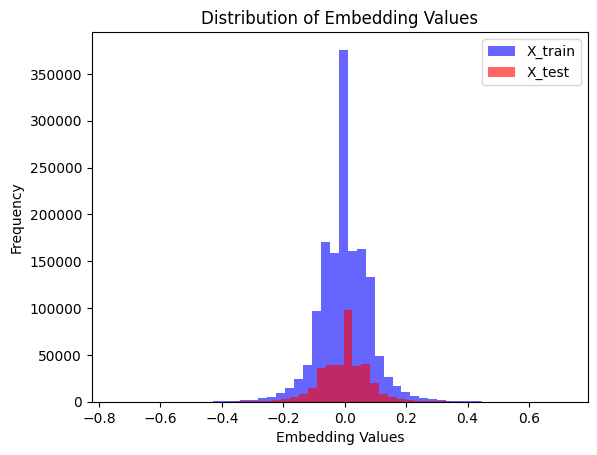

In [124]:
import matplotlib.pyplot as plt

plt.hist(X_train.flatten(), bins=50, alpha=0.6, color='b', label='X_train')
plt.hist(X_test.flatten(), bins=50, alpha=0.6, color='r', label='X_test')
plt.xlabel('Embedding Values')
plt.ylabel('Frequency')
plt.title('Distribution of Embedding Values')
plt.legend()
plt.show()

The histogram visualizes the distribution of embedding values for the training and testing datasets. The x-axis represents the embedding values, while the y-axis shows their frequency. 

- The blue bars represent the distribution of embedding values in the training set (`X_train`).
- The red bars represent the distribution of embedding values in the testing set (`X_test`).

From the histogram, we can observe that both distributions are centered around zero and have a similar shape. This indicates that the embedding values are consistently distributed between the training and testing datasets, supporting the findings from the mean and standard deviation calculations.


In [125]:
from sklearn.manifold import TSNE
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('ADVB data/GoogleNews-vectors-negative300.bin', binary=True)

In [126]:
def extract_all_emojis(df):
    all_emojis = []
    for emoji_list in df['emojis']:
        for emojis in emoji_list:
            all_emojis.append(emojis)
    return list(all_emojis)


words = [word for text in data['lemmatized_text'] for word in text.split()]

# Count word frequencies
word_counts = Counter(words)

# Select the most frequent words
N = 100  # Number of most frequent words to select
most_common_words = word_counts.most_common(N)
most_common_words = [word for word, count in most_common_words]

# Extract embeddings for the most frequent words
word2vec_model = KeyedVectors.load_word2vec_format('ADVB data/GoogleNews-vectors-negative300.bin', binary=True)
word_embeddings = {word: word2vec_model[word] for word in most_common_words if word in word2vec_model}

# Extract emoji frequencies
emojis = extract_all_emojis(data)
emoji_counts = Counter(emojis)

# Select the most frequent emojis
most_common_emojis = emoji_counts.most_common(N)
most_common_emojis = [emoji for emoji, count in most_common_emojis]

# Extract embeddings for the most frequent emojis
emoji2vec_model = KeyedVectors.load_word2vec_format('ADVB data/emoji2vec.bin', binary=True)
emoji_embeddings = {emoji: emoji2vec_model[emoji] for emoji in most_common_emojis if emoji in emoji2vec_model}

# Combine word and emoji embeddings
combined_embeddings = {**word_embeddings, **emoji_embeddings}

# Prepare data for t-SNE
labels = list(combined_embeddings.keys())
embeddings = np.array(list(combined_embeddings.values()))

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(embeddings)

# Create the scatter plot
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 text=labels,  # Add text labels
                 opacity=1)

# Change the plot background color
fig.update_layout(dict(plot_bgcolor='white'))

# Update the axis lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set the plot title
fig.update_layout(title_text="t-SNE Visualization of Most Frequent Words and Emojis")

# Update the marker size
fig.update_traces(marker=dict(size=5))

fig.show()

### t-SNE Visualization of Most Frequent Words and Emojis

In this section, we performed t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize the relationships between the most frequent words and emojis in the dataset. The goal was to identify which words and emojis are closely related in the embedding space.

#### Key Steps:
1. **Word and Emoji Frequency Extraction**:
   - We extracted the most frequent words from the lemmatized text.
   - Similarly, we extracted the most frequent emojis from the dataset.

2. **Embedding Extraction**:
   - We used pre-trained Word2Vec and Emoji2Vec models to obtain embeddings for the most frequent words and emojis.

3. **t-SNE Embedding**:
   - We combined the embeddings of words and emojis.
   - We applied t-SNE to reduce the high-dimensional embeddings to two dimensions for visualization.

4. **Scatter Plot**:
   - We plotted the t-SNE results, where each point represents a word or an emoji.
   - The plot helps us see which words and emojis form clusters, indicating semantic similarities.

#### Observations:
- Certain clusters are easily identifiable, such as heart emojis clustering with words related to love.
- Similarly, birthday-related emojis cluster with the word "birthday".

This visualization aids in understanding the semantic relationships and grouping tendencies within the text and emoji data.


 # KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.7277
Precision: 0.7286
Recall: 0.7277
F1 Score: 0.7280
Confusion Matrix:
[[120  12  16  21]
 [ 17 122   4  17]
 [ 14   8 107  10]
 [ 24  18   7 100]]


# MLP

In [128]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined and are in vectorized form
# Convert pandas Series to numpy arrays if necessary
if isinstance(X_train, pd.Series):
    X_train = np.array(X_train.tolist())
if isinstance(X_test, pd.Series):
    X_test = np.array(X_test.tolist())
if isinstance(y_train, pd.Series):
    y_train = np.array(y_train.tolist())
if isinstance(y_test, pd.Series):
    y_test = np.array(y_test.tolist())

# Define a more complex neural network
def create_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = create_model(input_dim, num_classes)

# Train the model
num_epochs = 30
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4699 - loss: 1.1566 - val_accuracy: 0.8077 - val_loss: 0.4654
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8407 - loss: 0.4607 - val_accuracy: 0.8279 - val_loss: 0.4331
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8550 - loss: 0.4180 - val_accuracy: 0.8279 - val_loss: 0.4331
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8680 - loss: 0.3822 - val_accuracy: 0.8158 - val_loss: 0.4258
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8876 - loss: 0.3411 - val_accuracy: 0.8178 - val_loss: 0.4764
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9050 - loss: 0.3040 - val_accuracy: 0.8219 - val_loss: 0.4618
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9103 - loss: 0.2680 - val_accuracy: 0.8158 - val_loss: 0.5040
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9173 - loss: 0.2579 - val_accuracy: 0.8117 - val_loss

# BERTweet + Random Forest Classifier

In [129]:
# import torch
# from transformers import AutoTokenizer, AutoModel
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# import nlpaug.augmenter.word as naw
# import emoji
# import re

# # Check data for empty rows or incorrect data
# data.dropna(subset=['lemmatized_text', 'Sentiment'], inplace=True)
# data = data[data['lemmatized_text'].map(len) > 0]

# # Define augmenters
# synonym_aug = naw.SynonymAug(aug_src='wordnet')

# # Function for text augmentation
# def augment_text(text, n=1):
#     augmented_texts = [synonym_aug.augment(text) for _ in range(n)]
#     return [' '.join(aug) if isinstance(aug, list) else aug for aug in augmented_texts]

# # Function to extract emojis from text
# def extract_emojis(text):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002700-\U000027BF"  # dingbats
#                            u"\U000024C2-\U0001F251" 
#                            "]+", flags=re.UNICODE)
#     return ''.join(emoji_pattern.findall(text))

# # Apply augmentation to increase the dataset three times
# augmented_texts = []
# augmented_labels = []
# augmented_emojis = []

# for index, row in data.iterrows():
#     # Add original text and emojis
#     augmented_texts.append(row['lemmatized_text'])
#     augmented_labels.append(row['Sentiment'])
#     augmented_emojis.append(extract_emojis(row['lemmatized_text']))
#     # Add augmented texts (2 times to increase threefold)
#     aug_texts = augment_text(row['lemmatized_text'], n=2)
#     augmented_texts.extend(aug_texts)
#     augmented_labels.extend([row['Sentiment']] * 2)
#     augmented_emojis.extend([extract_emojis(text) for text in aug_texts])

# # Create augmented data
# augmented_data = pd.DataFrame({
#     'lemmatized_text': augmented_texts,
#     'Sentiment': augmented_labels,
#     'emojis': augmented_emojis
# })

# # Save augmented data to CSV file
# augmented_data.to_csv('augmented_dataset.csv', index=False)

# # Load BERTweet tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
# model = AutoModel.from_pretrained("vinai/bertweet-base")

# # Function to get text embeddings
# def get_embeddings(texts, tokenizer, model):
#     inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy()

# # Get embeddings for all texts in the dataset
# text_embeddings = get_embeddings(augmented_data['lemmatized_text'].tolist(), tokenizer, model)

# # Convert emojis to one-hot vectors
# emoji_set = set(''.join(augmented_data['emojis'].tolist()))
# emoji_dict = {e: i for i, e in enumerate(emoji_set)}

# def get_emoji_embeddings(emojis, emoji_dict, length):
#     embeddings = np.zeros((len(emojis), length))
#     for i, emoji_str in enumerate(emojis):
#         for char in emoji_str:
#             if char in emoji_dict:
#                 embeddings[i, emoji_dict[char]] = 1
#     return embeddings

# emoji_embeddings = get_emoji_embeddings(augmented_data['emojis'].tolist(), emoji_dict, len(emoji_dict))

# # Combine text and emoji embeddings
# combined_embeddings = np.concatenate((text_embeddings, emoji_embeddings), axis=1)

# # Convert embeddings to DataFrame and add labels
# embeddings_df = pd.DataFrame(combined_embeddings)
# embeddings_df['Sentiment'] = augmented_data['Sentiment'].values

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(embeddings_df.drop(columns=['Sentiment']), embeddings_df['Sentiment'], test_size=0.2, random_state=42)

# # Train Random Forest using Grid Search to find the best parameters
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# # Predict on test set
# y_pred = grid_search.best_estimator_.predict(X_test)

# # Calculate metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print("Confusion Matrix:")
# print(conf_matrix)

# Siamese Neural Network

In [130]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Conv1D, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adagrad
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.spatial.distance import cosine
import time
import pickle

class SiameseNeuralNetwork:
    def __init__(self, input_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.model, self.embedding_model = self.build_model()
        
    def build_model(self):
        input_shape = (self.input_dim,)
        input_anchor = Input(shape=input_shape, name="anchor")
        input_positive = Input(shape=input_shape, name="positive")
        input_negative = Input(shape=input_shape, name="negative")
        
        # Reshape the input to add the time dimension
        reshape_layer = Reshape((self.input_dim, 1))
        
        # Shared convolutional layers
        conv_layer1 = Conv1D(64, kernel_size=3, activation='relu')
        conv_layer2 = Conv1D(32, kernel_size=3, activation='relu')
        flatten_layer = Flatten()
        dense_layer = Dense(150, activation='relu', kernel_initializer='he_normal')
        
        def process_input(input_data):
            reshaped_input = reshape_layer(input_data)
            conv_output1 = conv_layer1(reshaped_input)
            conv_output2 = conv_layer2(conv_output1)
            flattened_output = flatten_layer(conv_output2)
            dense_output = dense_layer(flattened_output)
            return dense_output
        
        # Processing anchor
        dense_anchor = process_input(input_anchor)
        
        # Processing positive
        dense_positive = process_input(input_positive)
        
        # Processing negative
        dense_negative = process_input(input_negative)
        
        # Stack to form the output
        outputs = Lambda(lambda x: K.stack(x, axis=1))([dense_anchor, dense_positive, dense_negative])
        
        model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=outputs)
        
        # Creating the embedding model
        embedding_model = Model(inputs=input_anchor, outputs=dense_anchor)
        
        optimizer = Adagrad()
        model.compile(loss=self.triplet_loss, optimizer=optimizer)
        
        return model, embedding_model

    def triplet_loss(self, y_true, y_pred, alpha=0.1):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        loss = K.mean(K.maximum(pos_dist - neg_dist + alpha, 0.0))
        return loss
    
    def create_triplets(self, X, y):
        triplets = []
        labels = []  # This is just a placeholder and not used in training
        unique_classes = np.unique(y)
        class_indices = {cls: np.where(y == cls)[0] for cls in unique_classes}
        
        for cls in unique_classes:
            class_idx = class_indices[cls]
            for i in range(len(class_idx)):
                anchor_idx = class_idx[i]
                pos_idx = np.random.choice(class_idx)
                
                neg_cls = np.random.choice(unique_classes[unique_classes != cls])
                neg_idx = np.random.choice(class_indices[neg_cls])
                
                triplets.append([X[anchor_idx], X[pos_idx], X[neg_idx]])
                labels.append([1, 0])  # Placeholder
        
        return np.array(triplets), np.array(labels)
    
    def fit(self, X_train, y_train, batch_size=32, epochs=10, validation_split=0.2):
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        start_time = time.time()
        print("Creating triplets...")
        X_train_triplets, y_train_triplets = self.create_triplets(X_train, y_train)
        pair_time = time.time()
        print(f"Triplets created in {pair_time - start_time:.2f} seconds\n")
        
        X_train_anchor = np.array([triplet[0] for triplet in X_train_triplets])
        X_train_positive = np.array([triplet[1] for triplet in X_train_triplets])
        X_train_negative = np.array([triplet[2] for triplet in X_train_triplets])
        
        self.model.fit(
            [X_train_anchor, X_train_positive, X_train_negative], y_train_triplets, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_split=validation_split,
            verbose=1
        )
    
    def get_embeddings(self, X):
        return self.embedding_model.predict(X)

        

# Load the preprocessed data
with open('ADVB data/preprocessed_data.pkl', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

# Verify the loaded data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Check and normalize data
print("NaNs in X_train:", np.isnan(X_train).sum(), "NaNs in X_test:", np.isnan(X_test).sum())
print("Infs in X_train:", np.isinf(X_train).sum(), "Infs in X_test:", np.isinf(X_test).sum())

X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

# Parameters
input_dim = 600 # Example input dimension

# Initialize the SimpleSiameseModel class
siamese_model = SiameseNeuralNetwork(input_dim)

# Train the model with validation split
siamese_model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.2)

# siamese_model.embedding_model.save('best_model.keras')

(2468, 600) (617, 600) (2468,) (617,)
NaNs in X_train: 0 NaNs in X_test: 0
Infs in X_train: 0 Infs in X_test: 0
Creating triplets...
Triplets created in 0.07 seconds

Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.1361 - val_loss: 0.1117
Epoch 2/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0409 - val_loss: 0.1071
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0332 - val_loss: 0.0979


In [131]:
from tensorflow.keras.models import load_model

# Load the embedding model
embedding_model = load_model('ADVB data/best_model.keras')


X_test = np.array(X_test)
y_test = np.array(y_test)

unique_classes = np.unique(y_test)
class_indices = {cls: np.where(y_test == cls)[0] for cls in unique_classes}

embeddings_test = embedding_model.predict(X_test)

y_pred = []
for i in range(len(X_test)):
    similarities = []
    for cls in unique_classes:
        class_embed = embeddings_test[class_indices[cls]]
        mean_embed = np.mean(class_embed, axis=0)
        similarity = 1 - cosine(mean_embed, embeddings_test[i])
        similarities.append(similarity)
    y_pred.append(unique_classes[np.argmax(similarities)])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.7812
Precision: 0.8086
Recall: 0.7812
F1 Score: 0.7855
Confusion Matrix:
[[144   0  14  11]
 [ 25 121   4  10]
 [ 21   1 114   3]
 [ 39   2   5 103]]


# Word Importance for sNN model

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


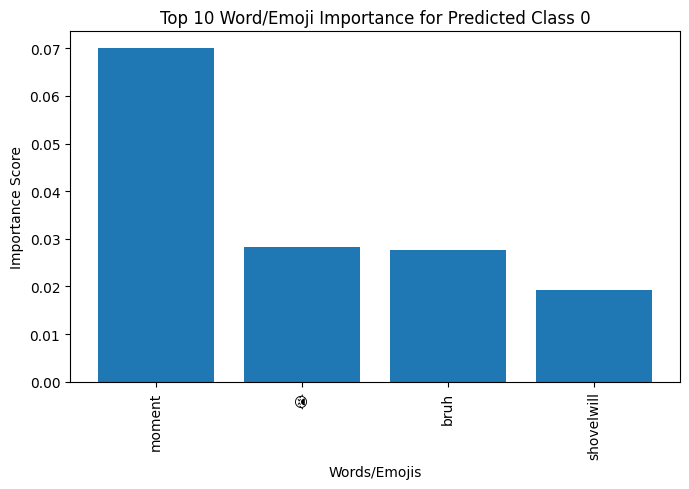

Predicted class for the [@r0yaltantrum @shovelwill bruh moment 😭]: 0, original class: 0


In [136]:
import numpy as np
import tensorflow as tf
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

class WordImportanceSiameseNN:
    def __init__(self, siamese_model, X_train, y_train, data):
        self.siamese_model = siamese_model
        self.X_train = X_train
        self.y_train = y_train
        self.data = data
        
        # Extract embeddings for training data
        self.embeddings_train = self.siamese_model.get_embeddings(X_train)
        
        # Compute class embeddings (mean embedding for each class from training data)
        self.class_indices = {cls: np.where(y_train == cls)[0] for cls in np.unique(y_train)}
        self.class_embeddings = {cls: np.mean(self.embeddings_train[self.class_indices[cls]], axis=0) for cls in np.unique(y_train)}

    def compute_word_importance(self, model, input_data, class_embedding):
        input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
        class_embedding = tf.convert_to_tensor(class_embedding, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            embeddings = model(input_data, training=False)
            similarity_score = 1 - tf.keras.losses.cosine_similarity(class_embedding, embeddings)
        grads = tape.gradient(similarity_score, input_data)
        return tf.reduce_mean(tf.abs(grads), axis=0).numpy()

    def predict_single_class(self, embedding_model, sample, unique_classes, class_embeddings):
        sample_embedding = embedding_model.predict(np.array([sample]))[0]
        similarities = []
        for cls in unique_classes:
            mean_embed = class_embeddings[cls]
            similarity = 1 - cosine(mean_embed, sample_embedding)
            similarities.append(similarity)
        predicted_class = unique_classes[np.argmax(similarities)]
        return predicted_class

    def get_contributions(self, importance_scores, combined_list):
        contributions = {item: importance for item, importance in zip(combined_list, importance_scores) if item in combined_list}
        return contributions

    def plot_importance(self, top_contributions, predicted_class):
        fig, ax = plt.subplots(figsize=(7, 5))
        top_items, top_scores = zip(*top_contributions)
        ax.bar(top_items, top_scores)
        ax.set_xlabel('Words/Emojis')
        ax.set_ylabel('Importance Score')
        ax.set_title(f'Top 10 Word/Emoji Importance for Predicted Class {predicted_class}')
        ax.tick_params(axis='x', rotation=90)
        plt.tight_layout()
        plt.show()

    def analyze_sample(self, index):
        # Prepare the sample
        for_text = np.vstack(self.data['text_embeddings'].iloc[index:index+1])
        for_emoji = np.vstack(self.data['emoji_embeddings'].iloc[index:index+1])
        first_sample = np.hstack((for_text, for_emoji))
        
        # Compute importance scores for the sample
        importance_scores_per_class = {}
        for cls in np.unique(self.y_train):
            importance_scores_per_class[cls] = self.compute_word_importance(
                self.siamese_model.embedding_model, first_sample, self.class_embeddings[cls]
            )
        
        # Predict the class for the sample
        predicted_class = self.predict_single_class(self.siamese_model.embedding_model, first_sample[0], np.unique(self.y_train), self.class_embeddings)
        
        # Prepare words and emojis for plotting
        sample_words = self.data['lemmatized_text'].iloc[index].split()
        sample_emojis = self.data['emojis'].iloc[index]
        sample_combined = sample_words + list(sample_emojis)
        
        # Compute contributions
        contributions_per_class = {}
        for cls in np.unique(self.y_train):
            contributions_per_class[cls] = self.get_contributions(importance_scores_per_class[cls], sample_combined)
        
        # Get top contributions for the predicted class
        sorted_contributions = sorted(contributions_per_class[predicted_class].items(), key=lambda item: item[1], reverse=True)
        top_contributions = sorted_contributions[:10]
        
        # Plot importance
        self.plot_importance(top_contributions, predicted_class)
        
        # Print the predicted class
        print(f"Predicted class for the [{self.data['Text'].iloc[index]}]: {predicted_class}, original class: {self.data['Sentiment'].iloc[index]}")

classifier = WordImportanceSiameseNN(siamese_model, X_train, y_train, data)
classifier.analyze_sample(1)